# Nested sampling for multiple spectra of the same object

Forward modeling of multiple spectra for the same object using modern atmospheric models and the ``dynesty`` Bayesian framework.

In [1]:
import seda # import the seda package
import importlib
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, StrMethodFormatter, NullFormatter
from astropy.io import fits, ascii
from dynesty import plotting as dyplot # to plot nested sampling results


    SEDA v0.4.0 package imported


Read the observed spectra of interest.

As an example here, let's read the near-infrared IRTF/SpeX, the mid-infrared JWST/NIRSpec, and the mid-infrared Spitzer/IRS spectra for the T8 (~750 K) brown dwarf 2MASS J04151954-0935066 in [Burgasser et al. (2004)](https://ui.adsabs.harvard.edu/abs/2004AJ....127.2856B/abstract), [Alejandro Merchan et al. (2025)](https://ui.adsabs.harvard.edu) and [Suárez & Metchev (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.5701S/abstract), respectively.

Read SpeX spectrum:

In [36]:
# path to the seda package
path_seda = os.path.dirname(os.path.dirname(seda.__file__))

SpeX_name = path_seda+'/docs/notebooks/data/0415-0935_IRTF_SpeX.dat'
SpeX = ascii.read(SpeX_name)
wl_SpeX = SpeX['wl(um)'] # um 
flux_SpeX = SpeX['flux(erg/s/cm2/A)'] # erg/s/cm2/A
eflux_SpeX = SpeX['eflux(erg/s/cm2/A)'] # erg/s/cm2/A

Read JWST NIRSpec spectrum

In [37]:
NIRSpec_name = path_seda+'/docs/notebooks/data/0415-0935_NIRSpec_spectrum.dat'
NIRSpec = ascii.read(NIRSpec_name)
wl_NIRSpec = NIRSpec['wl(um)'] # um 
flux_NIRSpec = NIRSpec['flux(Jy)'] # Jy
eflux_NIRSpec = NIRSpec['eflux(Jy)'] # Jy

# convert NIRSpec fluxes from Jy to erg/s/cm2/A
out_convert_flux = seda.synthetic_photometry.convert_flux(wl=wl_NIRSpec, 
                                                          flux=flux_NIRSpec, 
                                                          eflux=eflux_NIRSpec, 
                                                          unit_in='Jy', 
                                                          unit_out='erg/s/cm2/A')
flux_NIRSpec = out_convert_flux['flux_out'] # in erg/s/cm2/A
eflux_NIRSpec = out_convert_flux['eflux_out'] # in erg/s/cm2/A

# remove a few negative fluxes and edge points
mask = (flux_NIRSpec>0) & ((wl_NIRSpec<3.68) | (wl_NIRSpec>3.79))
wl_NIRSpec = wl_NIRSpec[mask]
flux_NIRSpec = flux_NIRSpec[mask]
eflux_NIRSpec = eflux_NIRSpec[mask]

Read IRS spectrum:

In [38]:
IRS_name = path_seda+'/docs/notebooks/data/0415-0935_IRS_spectrum.dat'
IRS = ascii.read(IRS_name)
wl_IRS = IRS['wl(um)'] # in um
flux_IRS = IRS['flux(Jy)'] # in Jy
eflux_IRS = IRS['eflux(Jy)'] # in Jy

# convert IRS fluxes from Jy to erg/s/cm2/A
out_convert_flux = seda.synthetic_photometry.convert_flux(wl=wl_IRS, flux=flux_IRS, 
                                                          eflux=eflux_IRS, 
                                                          unit_in='Jy', 
                                                          unit_out='erg/s/cm2/A')
flux_IRS = out_convert_flux['flux_out'] # in erg/s/cm2/A
eflux_IRS = out_convert_flux['eflux_out'] # in erg/s/cm2/A

Plot SED to check everything looks okay:

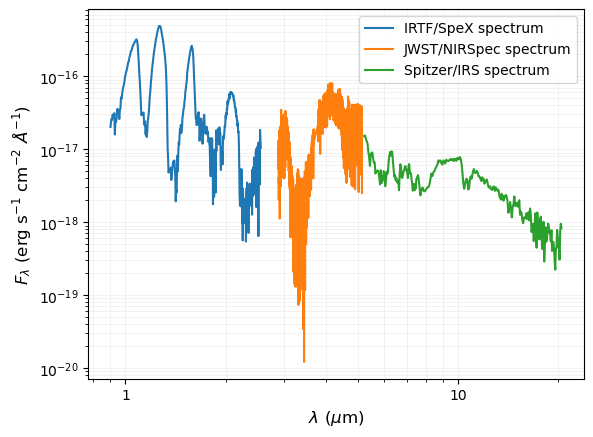

In [5]:
fig, ax = plt.subplots()

plt.plot(wl_SpeX, flux_SpeX, label='IRTF/SpeX spectrum')
plt.plot(wl_NIRSpec, flux_NIRSpec, label='JWST/NIRSpec spectrum')
plt.plot(wl_IRS, flux_IRS, label='Spitzer/IRS spectrum')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.xscale('log')
plt.yscale('log')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

ax.grid(True, which='both', color='gainsboro', linewidth=0.5, alpha=0.5)
ax.legend()

plt.xlabel(r'$\lambda\ (\mu$m)', size=12)
plt.ylabel(r'$F_\lambda\ ($erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=12)

plt.show()

**Read input data**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.InputData).

For any SEDA function, we can also see the function description directly on the notebook with the command ``help()``, e.g.:

``help(seda.input_parameters.InputData)``


Define lists with the input spectra:

In [6]:
# wavelenghts
wl_spectra = [wl_SpeX, wl_NIRSpec, wl_IRS] # in um
# fluxes
flux_spectra = [flux_SpeX, flux_NIRSpec, flux_IRS] # in erg/s/cm2/A
# flux uncertainties
eflux_spectra = [eflux_SpeX, eflux_NIRSpec, eflux_IRS] # in erg/s/cm2/A
# specify flux units
flux_unit = 'erg/s/cm2/A'

# resolution of each input spectrum (used to convolve the model spectra)
res = [100, 2700, 100] # SpeX, NIRSpec, IRS

# distance to the target (optional and used to derive a radius)
distance = 5.71 # pc (parallax=175.2+-1.7; Dupuy-Liu2012)
edistance = 0.06 # pc

# load all the input data parameters
my_data = seda.input_parameters.InputData(wl_spectra=wl_spectra, 
                                          flux_spectra=flux_spectra, 
                                          eflux_spectra=eflux_spectra, 
                                          flux_unit=flux_unit, 
                                          res=res, distance=distance, 
                                          edistance=edistance)


   Input data loaded successfully:
      3 spectra


Download (if not yet) the atmospheric models you want to use. 

Use the commands below to see the available atmospheric models, the links to download them, and other relevant information from models. You can read more about the model [here](https://seda.readthedocs.io/en/latest/overview.html#available-atmospheric-models).

Also consider [this tutorial](https://seda.readthedocs.io/en/latest/notebooks/tutorial_models_examination.html) to explore the free parameters in the models and their coverage.

In [7]:
# available atmospheric models
seda.models.Models().available_models

['BT-Settl',
 'ATMO2020',
 'Sonora_Elf_Owl',
 'SM08',
 'Sonora_Bobcat',
 'Sonora_Diamondback',
 'Sonora_Cholla',
 'LB23']

In [8]:
# some parameters of interest from a selected model
model = 'Sonora_Elf_Owl'
print(seda.models.Models(model).ref) # reference
print(seda.models.Models(model).ADS) # link to paper
print(seda.models.Models(model).download) # link to download the models
seda.models.Models(model).params_unique # coverage of free parameters in the grid

Mukherjee et al. (2024)
https://ui.adsabs.harvard.edu/abs/2024ApJ...963...73M/abstract
['https://zenodo.org/records/10385987', 'https://zenodo.org/records/10385821', 'https://zenodo.org/records/10381250']


{'Teff': array([ 275.,  300.,  325.,  350.,  375.,  400.,  425.,  450.,  475.,
         500.,  525.,  550.,  575.,  600.,  650.,  700.,  750.,  800.,
         850.,  900.,  950., 1000., 1100., 1200., 1300., 1400., 1500.,
        1600., 1700., 1800., 1900., 2000., 2100., 2200., 2300., 2400.]),
 'logg': array([3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 ]),
 'logKzz': array([2., 4., 7., 8., 9.]),
 'Z': array([-1. , -0.5,  0. ,  0.5,  0.7,  1. ]),
 'CtoO': array([0.5, 1. , 1.5, 2. , 2.5])}

**Read model grid options**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.ModelOptions).

In [9]:
# select the atmospheric models of interest
model = 'Sonora_Elf_Owl'

# path to the directory or directories containing the model spectra
# (update it to your own path)
my_path = '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Elf_Owl/spectra/'
model_dir = [my_path+'output_700.0_800.0/',
             my_path+'output_850.0_950.0/',
            ]

# set parameter ranges to select a grid subset and to be used as uniform priors
# when a free parameter range is not specified, the whole grid range will be considered
params_ranges = {
    'Teff': [700, 900], # Teff range
    'logg': [4.0, 5.0] # logg range
}

# load model options
my_model = seda.input_parameters.ModelOptions(model=model, model_dir=model_dir,
                                              params_ranges=params_ranges)


   Model options loaded successfully


**Tip:** If you plan to model several spectra from the same instrument (same resolution), you can save the convolved model spectra to reuse them and do subsequent fits much faster. For this, set the parameter ``path_save_spectra_conv`` in ``seda.ModelOptions`` above to a folder path where you want to store the convolved spectra. Once the spectra are stored, the next time you run the code just replace ``model_dir`` by the path you used in ``path_save_spectra_conv`` and set ``skip_convolution=True`` to avoid the model convolution. This was implemented thanks to [issue](https://github.com/suarezgenaro/seda/issues/14).

**Read Bayes fit options**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.BayesOptions).

Consider the default full wavelength range of each input spectrum for the fits. Otherwise, we can use the parameter ``fit_wl_range`` to set different fit ranges. 

In [22]:
# choose a filename (optional) to save the sampling results as a pickle file
# it is convenient to set a non-default name when running 
# the code several times in the same folder to avoid overwriting results
bayes_pickle_file = f'{model}_bayesian_sampling_multiple_spectra.pickle'

# radius range for the sampling
R_range = np.array((0.6, 1.0)) # Rjup

my_bayes = seda.input_parameters.BayesOptions(my_data=my_data, my_model=my_model, 
                                              R_range=R_range, 
                                              bayes_pickle_file=bayes_pickle_file)


For input spectrum 1 of 3

      3000 model spectra selected with:
         Teff range = [700, 900]
         logg range = [4.0, 5.0]


Reading, convolving, and resampling model grid:   0%|          | 0/3000 [00:00<?, ?it/s]

      elapsed time: 8.1 min

For input spectrum 2 of 3

      3000 model spectra selected with:
         Teff range = [700, 900]
         logg range = [4.0, 5.0]


Reading, convolving, and resampling model grid:   0%|          | 0/3000 [00:00<?, ?it/s]

      elapsed time: 2.1 min

For input spectrum 3 of 3

      3000 model spectra selected with:
         Teff range = [700, 900]
         logg range = [4.0, 5.0]


Reading, convolving, and resampling model grid:   0%|          | 0/3000 [00:00<?, ?it/s]

      elapsed time: 6.9 min

   Bayes fit options loaded successfully


**Run nested sampling**

In [23]:
out_bayes = seda.bayes_fit.bayes(my_bayes)


   Estimate Bayesian posteriors

      Uniform priors:
         Teff range = [700. 900.]
         logg range = [4. 5.]
         logKzz range = [2. 9.]
         Z range = [-1.  1.]
         CtoO range = [0.5 2.5]
         R range = [0.6 1. ]

   Starting dynesty...


9802it [44:35,  1.99s/it, batch: 0 | bound: 118 | nc: 166 | ncall: 105720 | eff(%):  9.228 | loglstar:   -inf < 8270.797 <    inf | logz: 8245.286 +/-  0.222 | dlogz: 1270.997 >  0.010]     /home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
9880it [46:25,  2.64it/s, batch: 0 | bound: 124 | nc: 8 | ncall: 110172 | eff(%):  8.927 | loglstar:   -inf < 8331.693 <    inf | logz: 8306.325 +/-  0.220 | dlogz: 1209.559 >  0.010]  /home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/dynesty/bounding.py:618: UserWarning: The enla

      Bayesian sampling results saved successfully

   Bayesian sampling ran successfully
      elapsed time: 2.9 hr


**Plot results**

The ``out_bayes`` output above from ``seda.bayes_fit.bayes`` is the input file to make plots.

If ``out_bayes`` is not in memory (if we reloaded the notebook or restarted the kernel), we need to open the pickle file first as below.

In [2]:
# open pickle file
bayes_pickle_file = 'Sonora_Elf_Owl_bayesian_sampling_multiple_spectra.pickle'
with open(bayes_pickle_file, 'rb') as file:
    # deserialize and retrieve the variable from the file
    out_bayes = pickle.load(file)

print('Posteriors loaded successfully')

Posteriors loaded successfully


Make corner plot using dynesty tools:

Quantiles:
Teff [(0.025, 768.700785139798), (0.5, 769.0881787432531), (0.975, 769.4876914163195)]
Quantiles:
logg [(0.025, 4.498917825911397), (0.5, 4.499863647034747), (0.975, 4.5002348022052985)]
Quantiles:
logKzz [(0.025, 2.0000012170301367), (0.5, 2.000031444315611), (0.975, 2.0001666530747717)]
Quantiles:
Z [(0.025, 0.04063528124555347), (0.5, 0.04264473614737889), (0.975, 0.0446348804294782)]
Quantiles:
CtoO [(0.025, 0.8426134548319418), (0.5, 0.8451070957885267), (0.975, 0.847544545815023)]
Quantiles:
R [(0.025, 0.7657537477416041), (0.5, 0.7665158900422326), (0.975, 0.7672458274140744)]


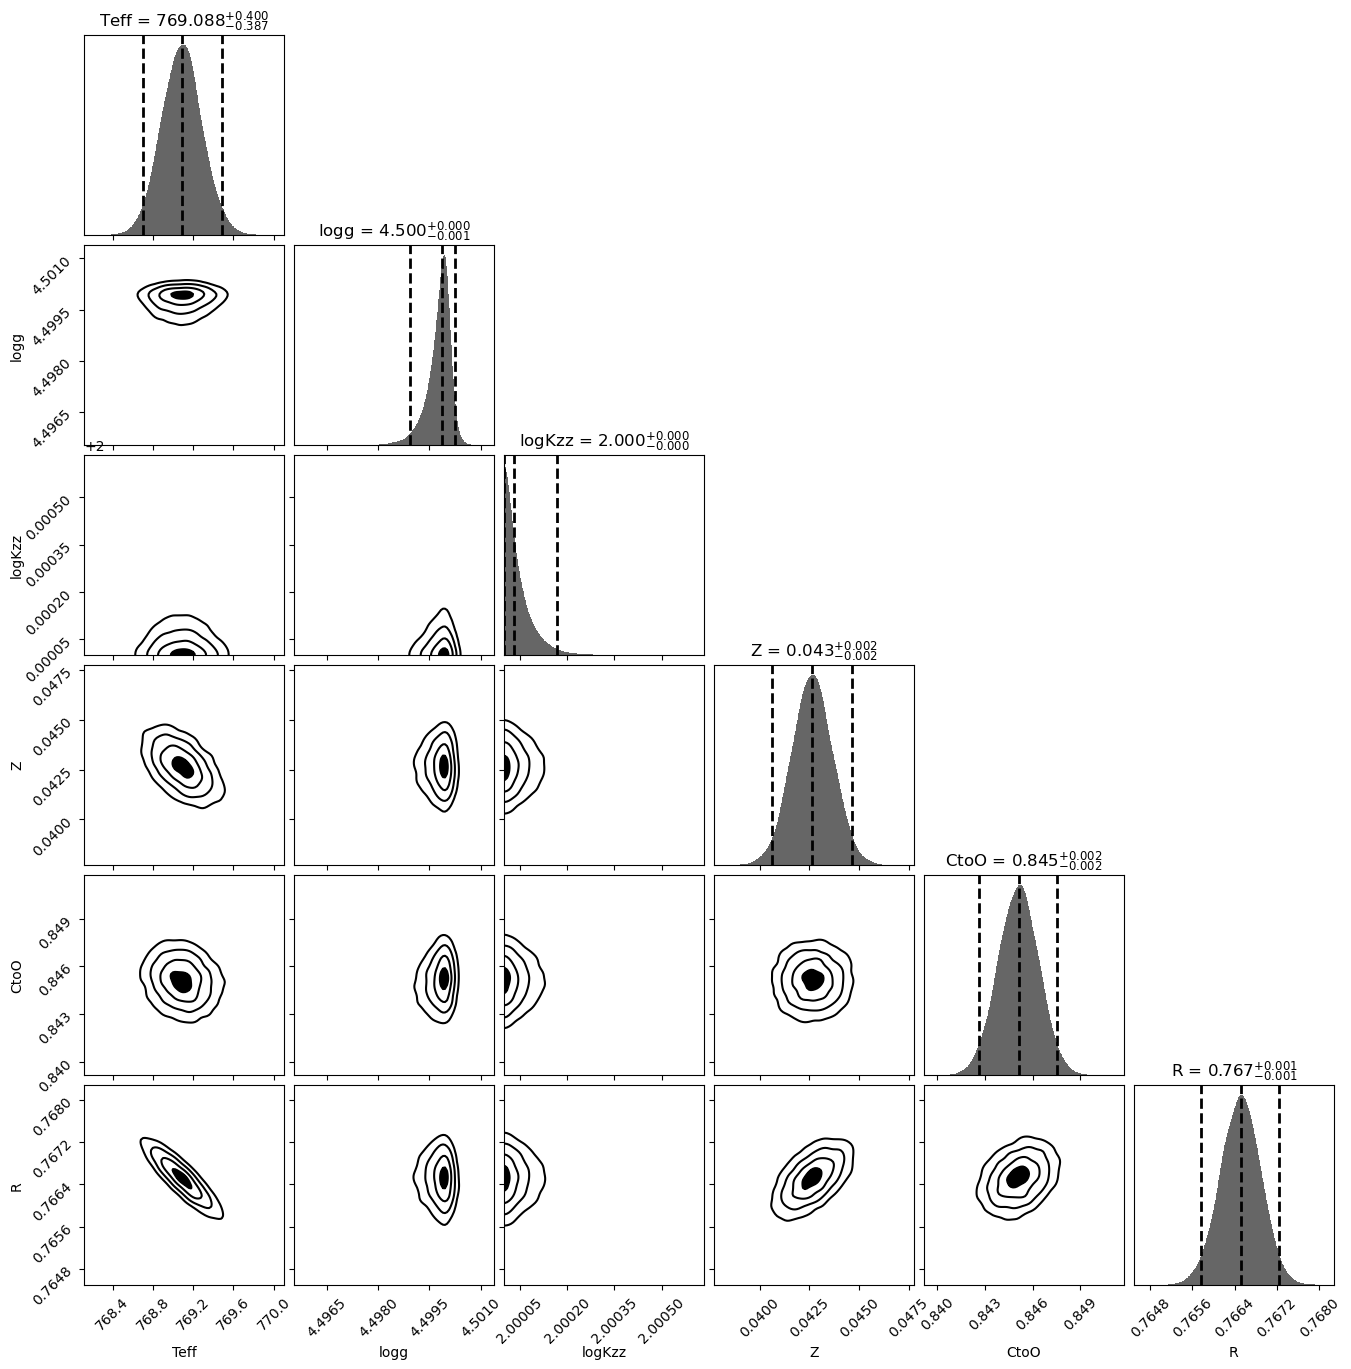

In [11]:
# plot the 2-D marginalized posteriors.
labels = list(out_bayes['my_bayes'].params_priors.keys())
fig, axes = dyplot.cornerplot(out_bayes['out_dynesty'], show_titles=True, 
                              verbose='true', title_fmt='.3f', 
                              title_kwargs={'y': 1.0}, labels=labels)

Plot a summary of the run

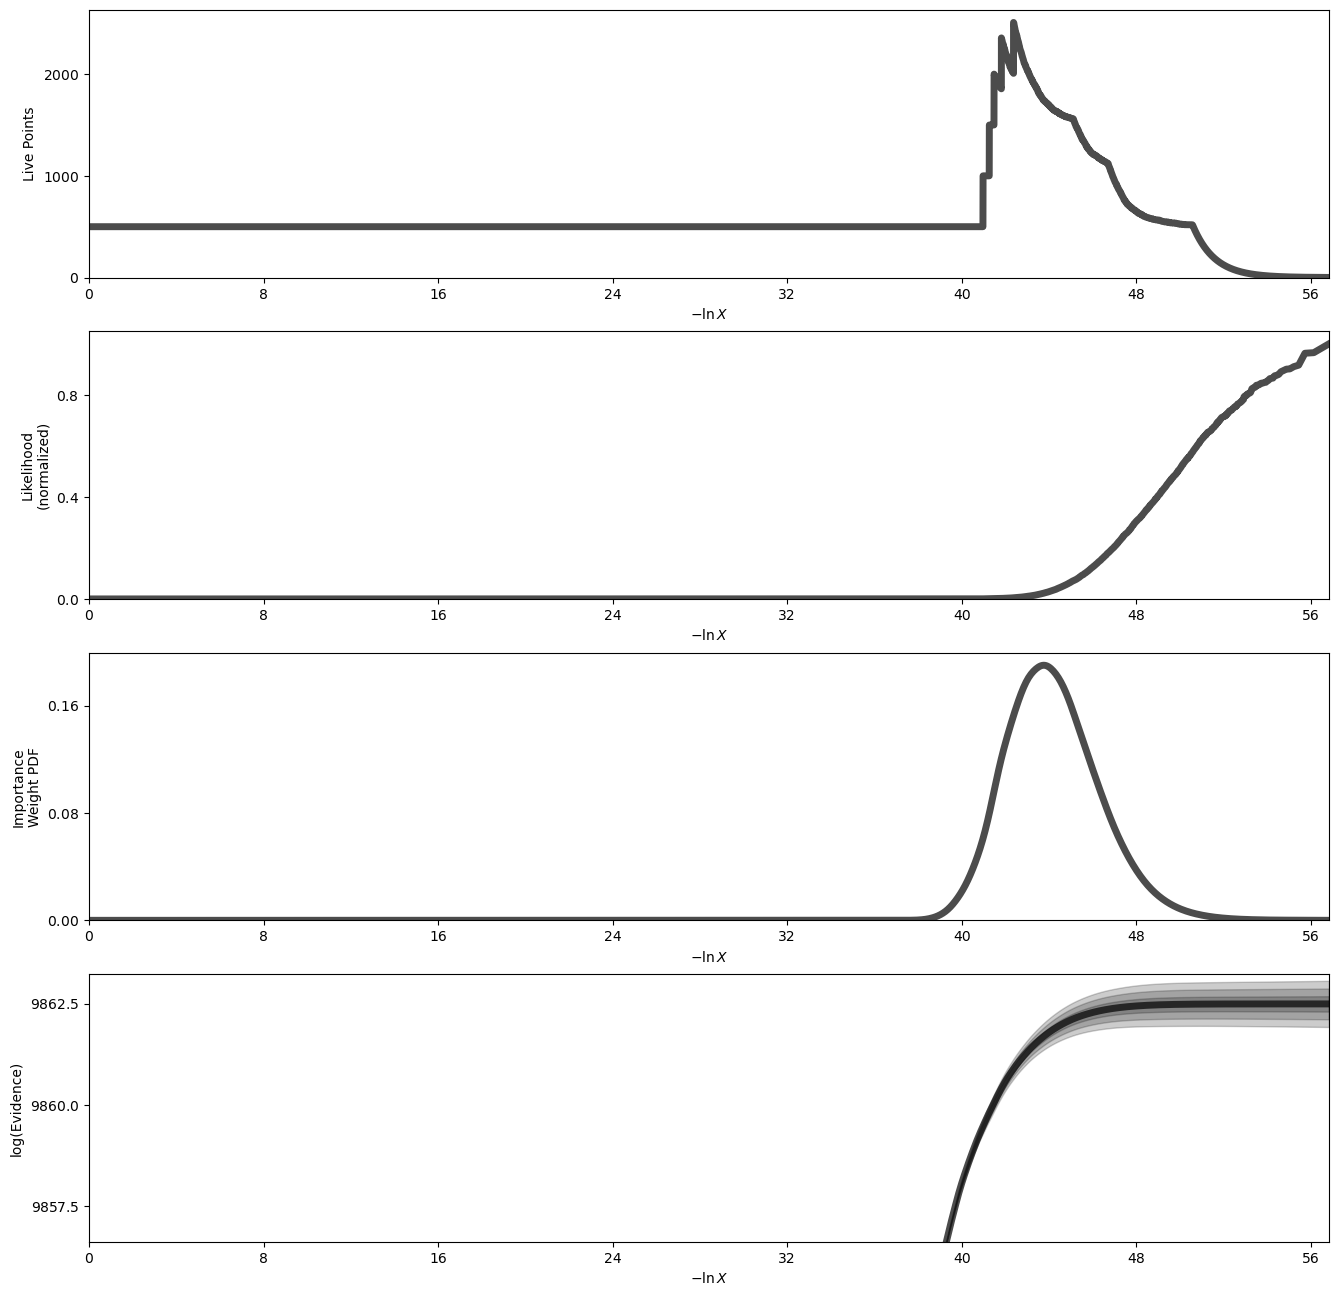

In [12]:
fig, axes = dyplot.runplot(out_bayes['out_dynesty'], color='black', 
                           mark_final_live=False, logplot=True)

Plot traces and 1-D marginalized posteriors

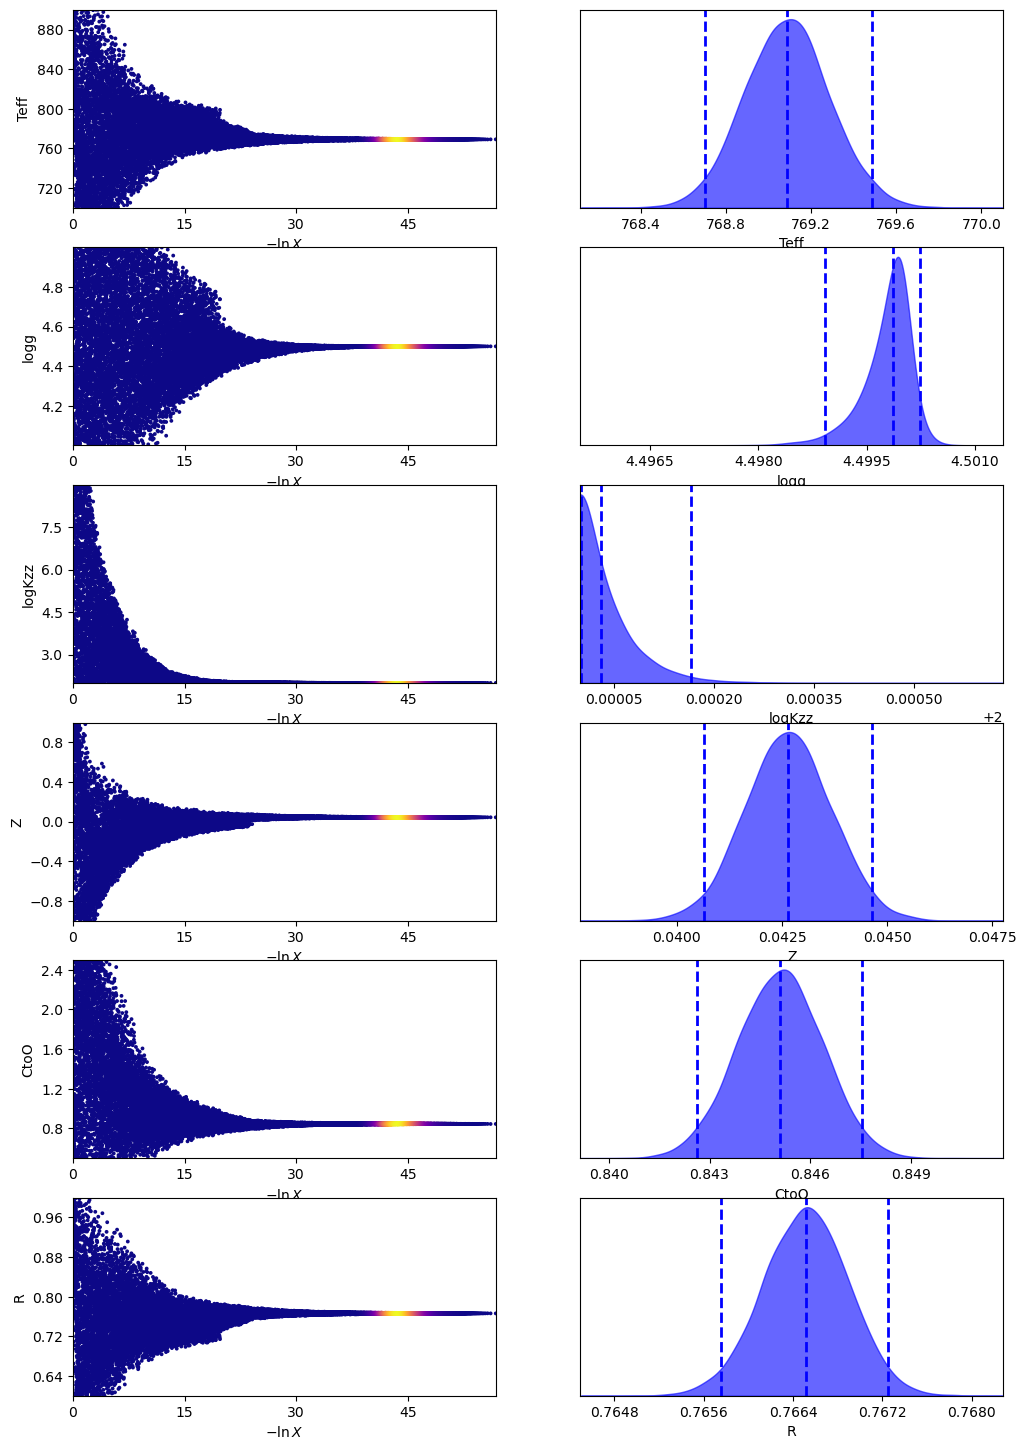

In [13]:
fig, axes = dyplot.traceplot(out_bayes['out_dynesty'], labels=labels)

**Plot the model spectrum using the median posterior parameters**

SED with the best model fit from the Bayesian sampling.

The pickle file generated by ``seda.bayes_fit.bayes`` and stored with the name ``my_bayes.bayes_pickle_file`` is the input file to make plots. We can provide the name by either using ``my_bayes.bayes_pickle_file`` (if ``my_bayes`` is in memory) or just typing it.

The best model fit will be generated by interpolating into a model grid subset around the median posteriors.

*Note that the Elf Owl models do not cover wavelenghts longer than 15 microns.*


For input spectrum 1 of 3

      8 model spectra selected with:
         Teff range = [750. 800.]
         logg range = [4.5 4.5]
         logKzz range = [2. 2.]
         Z range = [0.  0.5]
         CtoO range = [0.5 1. ]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 1.0 s

For input spectrum 2 of 3

      8 model spectra selected with:
         Teff range = [750. 800.]
         logg range = [4.5 4.5]
         logKzz range = [2. 2.]
         Z range = [0.  0.5]
         CtoO range = [0.5 1. ]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s

For input spectrum 3 of 3

      8 model spectra selected with:
         Teff range = [750. 800.]
         logg range = [4.5 4.5]
         logKzz range = [2. 2.]
         Z range = [0.  0.5]
         CtoO range = [0.5 1. ]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 1.0 s


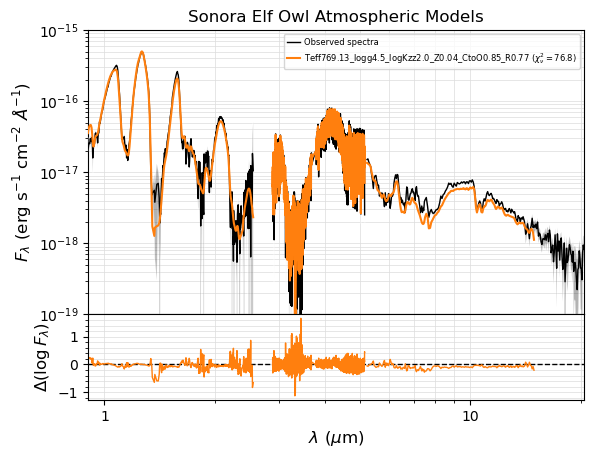

In [43]:
# using default logarithmic scale for fluxes
seda.plots.plot_bayes_fit(bayes_pickle_file, xlog=True, 
                          yrange=[1e-19, 1e-15])#, ori_res=True)

Zoom in on the SpeX spectrum:


For input spectrum 1 of 3

      8 model spectra selected with:
         Teff range = [750. 800.]
         logg range = [4.5 4.5]
         logKzz range = [2. 2.]
         Z range = [0.  0.5]
         CtoO range = [0.5 1. ]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 1.0 s

For input spectrum 2 of 3

      8 model spectra selected with:
         Teff range = [750. 800.]
         logg range = [4.5 4.5]
         logKzz range = [2. 2.]
         Z range = [0.  0.5]
         CtoO range = [0.5 1. ]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s

For input spectrum 3 of 3

      8 model spectra selected with:
         Teff range = [750. 800.]
         logg range = [4.5 4.5]
         logKzz range = [2. 2.]
         Z range = [0.  0.5]
         CtoO range = [0.5 1. ]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 1.0 s


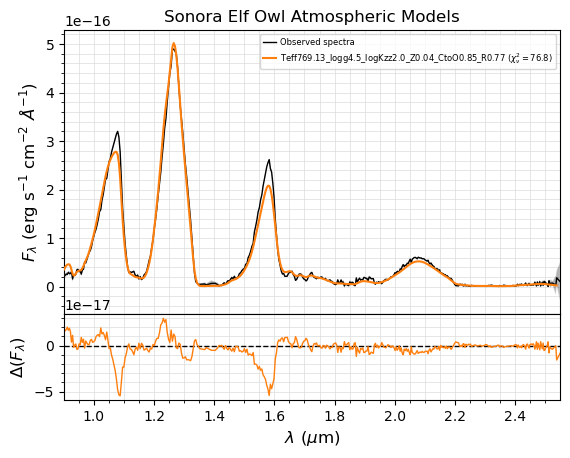

In [39]:
# plot fluxes in linear scale
seda.plots.plot_bayes_fit(bayes_pickle_file, ylog=False,
                          xrange=[wl_SpeX.min(), wl_SpeX.max()])

Zoom in on the NIRSpec spectrum:


For input spectrum 1 of 3

      8 model spectra selected with:
         Teff range = [750. 800.]
         logg range = [4.5 4.5]
         logKzz range = [2. 2.]
         Z range = [0.  0.5]
         CtoO range = [0.5 1. ]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 1.0 s

For input spectrum 2 of 3

      8 model spectra selected with:
         Teff range = [750. 800.]
         logg range = [4.5 4.5]
         logKzz range = [2. 2.]
         Z range = [0.  0.5]
         CtoO range = [0.5 1. ]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s

For input spectrum 3 of 3

      8 model spectra selected with:
         Teff range = [750. 800.]
         logg range = [4.5 4.5]
         logKzz range = [2. 2.]
         Z range = [0.  0.5]
         CtoO range = [0.5 1. ]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 1.0 s


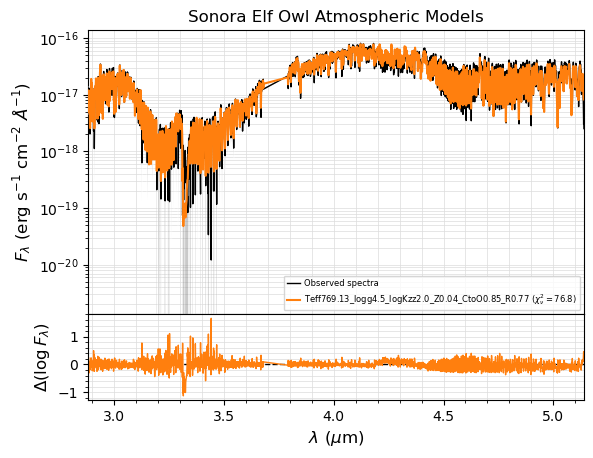

In [40]:
# plot fluxes in log scale
seda.plots.plot_bayes_fit(bayes_pickle_file, 
                          xrange=[wl_NIRSpec.min(), wl_NIRSpec.max()])

Zoom in on the IRS spectrum:


For input spectrum 1 of 3

      8 model spectra selected with:
         Teff range = [750. 800.]
         logg range = [4.5 4.5]
         logKzz range = [2. 2.]
         Z range = [0.  0.5]
         CtoO range = [0.5 1. ]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 1.0 s

For input spectrum 2 of 3

      8 model spectra selected with:
         Teff range = [750. 800.]
         logg range = [4.5 4.5]
         logKzz range = [2. 2.]
         Z range = [0.  0.5]
         CtoO range = [0.5 1. ]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s

For input spectrum 3 of 3

      8 model spectra selected with:
         Teff range = [750. 800.]
         logg range = [4.5 4.5]
         logKzz range = [2. 2.]
         Z range = [0.  0.5]
         CtoO range = [0.5 1. ]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 1.0 s

      7206 model spectra

      8 model spectra selected with:
         Teff range = [750. 800.]
         logg range = [4.5 4.5]
         logKzz range = [2. 2.]
         Z range = [0.  0.5]
         CtoO range = [0.5 1. ]


Reading model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s


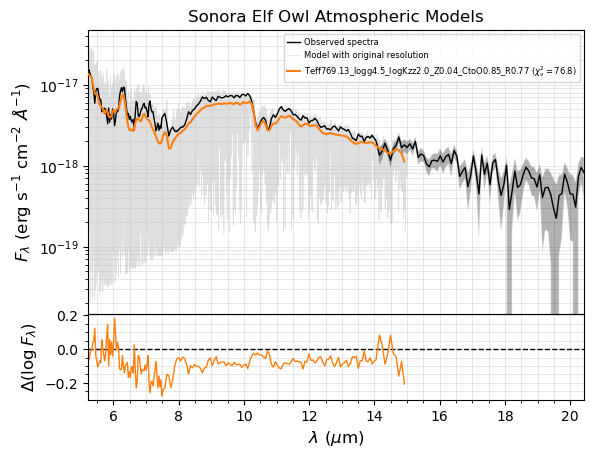

In [42]:
# plot fluxes in log scale
seda.plots.plot_bayes_fit(bayes_pickle_file, 
                          xrange=[wl_IRS.min(), wl_IRS.max()],
                          ori_res=True)